In [101]:
from tsai.imports import *
from tsai.models.layers import *
from torchinfo import summary
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from scipy import signal
from PyEMD import EMD
from PyEMD import EEMD
import pywt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [102]:
num_class = 12
close_num = 5 # 5, 7, 9, 11 注意（close numを使ってるとこと整合性とれてるか）
batch_size = 64
learning_rate = 0.00001
num_epochs = 300
sequence_len = 250 * 5 # sampling_rate * second　matlabで250Hzにresampleされているはず
overlap = int(sequence_len * 0.3)
alpha = 0.2

### マルチレベルの要素に対してMADを適用する

In [103]:
from scipy.stats import median_abs_deviation

def universal_wavelet(data):
    coeffs = pywt.wavedec(data,'db8',level=6)
    coeffs_flat = []
    # counter = 0

    for i in range(len(coeffs)):
        flat = coeffs[i].flatten()
        N_samples = len(flat)
        mad = median_abs_deviation(flat, axis=None)
        hat_sigma = mad / 0.6745 # estimate of standard deviation
        thre_universal = hat_sigma * np.sqrt(2 * np.log(N_samples))
    # have calculated threshold value so far

    # need to shrink coeffs while looping lists
    for i in range(len(coeffs)):
        for j in range(len(coeffs[i])):
            for k in range(len(coeffs[i][j])):
                coeff = coeffs[i][j][k]
                if np.abs(coeff) > thre_universal:
                    coeffs[i][j][k] = np.sign(coeff) * (np.abs(coeff) - thre_universal)
                else:
                    coeffs[i][j][k] = 0
    
    rec = pywt.waverec(coeffs, 'db8')
    return rec

In [104]:
def segmentation(end_idx, sequence_len, overlap, data_list):
    """
    データのセグメンテーションを行う
    segmentation(len(data_np_unfil_norm), sequence_len, overlap, data_list)
    """
    seg_list = []

    for data in data_list:
        n = 0
        n_stop = sequence_len
        data_segs = []
        while n_stop < end_idx:
            n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
            n_stop = n_start + sequence_len
            seg = data[n_start:n_stop].copy()
            if len(seg) == sequence_len:
                data_segs.append([seg])
            n += 1
        seg_list.append(data_segs)
    return seg_list

#### sampling rate 250Hz 5sで1250 points

In [105]:
from scipy import signal
data_list = []
seg_list = []

for i in range(1, 12 + 1):
    scaler = StandardScaler()
    file_path = "./data/Keio Hospital/BPF_distance%02d.csv" % i
    csv = pd.read_csv(file_path)
    csv = csv.to_numpy()
    csv = scaler.fit_transform(csv)
    csv = universal_wavelet(csv) # waveletを用いない場合はコメントアウト
    scaler = MinMaxScaler()
    csv = scaler.fit_transform(csv)

    data_list.append(csv[:, 1]) # waveletを用いない場合はコメントアウト
    # data_list.append(csv) # waveletを用いる場合はコメントアウト
seg_list = segmentation(len(csv), sequence_len, overlap, data_list)

/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/pywt/_multilevel.py:43: U

In [106]:
seg_re = np.reshape(seg_list, (3072, 1, 1250))
seg_re.shape

(3072, 1, 1250)

In [107]:
labels = []
for i in range(len(seg_list)):
    for j in range(len(seg_list[i])):
        if i <= close_num:
            labels.append(i)
        else:
            labels.append(close_num + 1) # for open set

In [108]:
seg_re.shape

(3072, 1, 1250)

In [109]:
data_set = []
# for i in range(len(seg_list)): # waveletありのとき
    # data_set.extend(seg_list[i])　
for i in range(len(seg_re)): # waveletなしのとき
    data_set.append(seg_re[i])

data_tensor_list = torch.tensor(data_set)
labels_tensor = torch.tensor(labels)
data_tensor_list.shape, labels_tensor.shape

(torch.Size([3072, 1, 1250]), torch.Size([3072]))

In [110]:
labels_tensor

tensor([0, 0, 0,  ..., 6, 6, 6])

In [111]:
class InceptionModule(Module):
    def __init__(self, ni, nf, ks=40, bottleneck=True):
        ks = [ks // (2**i) for i in range(3)]
        ks = [k if k % 2 != 0 else k - 1 for k in ks]  # ensure odd ks
        bottleneck = bottleneck if ni > 1 else False
        self.bottleneck = Conv1d(ni, nf, 1, bias=False) if bottleneck else noop
        self.convs = nn.ModuleList([Conv1d(nf if bottleneck else ni, nf, k, bias=False) for k in ks])
        self.maxconvpool = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), Conv1d(ni, nf, 1, bias=False)])
        self.concat = Concat()
        self.bn = BN1d(nf * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        x = self.concat([l(x) for l in self.convs] + [self.maxconvpool(input_tensor)])
        return self.act(self.bn(x))


@delegates(InceptionModule.__init__)
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, **kwargs))
            if self.residual and d % 3 == 2: 
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None))
        self.add = Add()
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))
        return x

    
@delegates(InceptionModule.__init__)
class InceptionTime(Module):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None, **kwargs):
        nf = ifnone(nf, nb_filters) # for compatibility
        self.inceptionblock = InceptionBlock(c_in, nf, **kwargs) # c_in is input channel num of conv1d
        self.gap = GAP1d(1)
        self.fc = nn.Linear(nf * 4, c_out) # c_out is 1d output size 
        self.fc_tsne = nn.Linear(c_out, 2)
        self.two_vecs_train = [] # list is faster in appending
        self.two_vecs_test = []

    def forward(self, x):
        x = self.inceptionblock(x)
        x = self.gap(x)
        # if self.training:
        #     self.two_vecs_train.append(two_dimensional_vec.tolist()) # あとでネストしたものをまとめてtensorかndarrayに変換するため
        # else:
        #     self.two_vecs_test.append(two_dimensional_vec.tolist())
        x = self.fc(x)
        return x
    
    def feature_save_train(self, x):
        x = self.fc_tsne(x)
        self.two_vecs_train.append(x)
    
    def feature_save_test(self, x):
        x = self.fc_tsne(x)
        self.two_vecs_test.append(x)


In [112]:
class HCU_Dataset(Dataset):
    def __init__(self, dataset, labels) -> None:
        # super().__init__()
        self.radar_heartbeat = dataset
        self.labels = labels
        

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()        
        return self.radar_heartbeat[idx], self.labels[idx]

    def __len__(self):
        return len(self.radar_heartbeat)


dataset = HCU_Dataset(data_tensor_list, labels_tensor)

In [113]:
from torch import log
softmax = nn.Softmax()

def softmax_loss(outputs, labels):
    loss = 0
    batch_size = len(labels)
    logsoftmax_out = log(softmax(outputs))
    for idx in range(batch_size):
        loss += 1.0 - logsoftmax_out[idx][labels[idx]]
    
    return loss / batch_size


from center_loss import CenterLoss
center_loss = CenterLoss(num_classes=close_num + 1, feat_dim=close_num + 1, use_gpu=True) # 入出力が同じだと一見変な感じがするが，交差エントロピーと違ってcenterlossを使うと最初から決めていれば，モデルの出力サイズを必ずしもクラス数に一致させる必要がないからfeat_dimを任意に設定できる．
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.05)


class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='cosface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss
        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599
        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 32.0 if not s else s
            self.m = 0.2 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.fc.to(device)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)
        # logを引き算に変えて計算
        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

cos_loss = AngularPenaltySMLoss(close_num + 1, close_num + 1, loss_type="cosface") # center_lossと同じ理由でin_featuresはクラス数でよい．


def triple_joint_loss(output, label, alpha):
    # alpha: hyper parameter
    output_only_truth = []
    for idx, x in enumerate(output):
        # x = x[labels[idx]] グローバル変数でlabelsが効いていただけで本来はlabelが意図していた書き方
        x = x[label[idx]]
        x = torch.tensor(x).to(device)
        output_only_truth.append([x])
    output_only_truth = torch.tensor(output_only_truth)
    output_only_truth = output_only_truth.float()
    output_only_truth = output_only_truth.to(device)
    # print(output.is_cuda, output_only_truth.is_cuda, label.is_cuda)

    return softmax_loss(output, label) + alpha * center_loss(output, label)
    # return softmax_loss(output, label) + alpha * center_loss(output, label) + cos_loss(output, label)
    # return cos_loss(output_only_truth, label)

### Cross Validation for Open set

In [115]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
torch.manual_seed(0)
# X = dataset
# y = labels
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0) # shuffle=Falseだとrandom_stateは何か数字を設定しても意味ないらしい
num_epochs = 150
mean_acc = 0
split_idx = 1535 # 5
# split_idx = 2047 # 7
# split_idx = 2559 # 9

dataset = HCU_Dataset(data_tensor_list, labels_tensor)

for Fold, (train_index, test_index) in enumerate(skf.split(data_tensor_list, labels_tensor)):
    print(f"Fold{Fold+1} Start!")
    # Prepare Open train Dataset
    open_train_index = [i for i in train_index if i <= split_idx]
    open_train_set = torch.utils.data.Subset(dataset, open_train_index)
    open_test_set = torch.utils.data.Subset(dataset, test_index)
    # Prepare Close train Dataset
    # train_set = torch.utils.data.Subset(dataset, train_index)
    # test_set = torch.utils.data.Subset(dataset, test_index) # openの場合も同じ

    Unknown_label = close_num + 1

    train_loader = DataLoader(dataset=open_train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=False)

    model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    from fastprogress.fastprogress import master_bar, progress_bar
    mb = master_bar(range(num_epochs))

    model.train()
    n_total_steps = len(train_loader)
    for epoch in mb:
        for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
            signals = torch.tensor(signals)
            signals = signals.float()
            signals = signals.to(device)
            labels = labels.to(device)

            # print(signals.size())
            outputs = model(signals)
            outputs = outputs.to(device)
            # print(outputs)
            loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels
            # loss = criterion(outputs, labels)
            # test_loss = triple_joint_loss(signals, one_hot_labels, alpha) # from test_loader?
            optimizer.zero_grad()
            optimizer_centloss.zero_grad()
            loss.backward()
            for param in center_loss.parameters():
                param.grad.data *= (1./alpha) # 98.98%を出したときはこれを書いていなかった→追加しても問題なし．
            optimizer.step()
            optimizer_centloss.step()
        mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))

    # For Confusion Matrix
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    model.eval()
    for threshold in thresholds:
      predicted_lists = np.zeros(0, dtype=np.int64)
      one_hot_labels_list = np.zeros(0, dtype=np.int64)
      with torch.no_grad():
        n_correct = 0
        n_samples = 0
        softmax = nn.Softmax()
        for i, (signals, one_hot_labels) in enumerate(test_loader):
          signals = torch.tensor(signals)
          signals = signals.float()
          signals = signals.to(device)
          one_hot_labels = one_hot_labels.to(device)
          # print(len(one_hot_labels))
          outputs = model(signals)
          # if i == 1:
          
            # print(outputs)
          for j, out in enumerate(outputs):
            outputs[j] = softmax(out)

          _, predicted = torch.max(outputs.data, 1) # predicted per batch size
          
          for idx in range(len(_)):
            if _[idx] < threshold:
              predicted[idx] = Unknown_label # 15, 20, 25
          # print(_, predicted, one_hot_labels)

          n_samples += one_hot_labels.size(0) # add batch_size
          n_correct += (predicted == one_hot_labels).sum().item()
          
          predicted_cp = predicted.to('cpu').detach().numpy().copy()
          one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
          predicted_lists = np.concatenate([predicted_lists, predicted_cp])
          one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
          
          acc = 100.0 * n_correct / n_samples
          # print(f'{n_correct} / {n_samples} = Acc: {acc} %')
        with open("./results/new/cross_val_result_HCU_BPF_unival_open_level6.txt", "a") as f:
          f.write(f"Fold{Fold+1}, Threshold{threshold}\n")
          f.write(classification_report(one_hot_labels_list, predicted_lists, digits=4) + "\n")


        cm = confusion_matrix(one_hot_labels_list, predicted_lists)
        sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
        plt.xlabel("Predicted Label", fontsize=13)
        plt.ylabel("Ground Truth", fontsize=13)
        fig_name = "cross_val_Fold{}_threshold{}.png".format(Fold, threshold)
        # plt.savefig("./figure/HCU_cross_val_BPF_uniwav_open6-6_level6/" + fig_name)
        plt.close()
      
      if threshold == 0.7:
        mean_acc += acc
print(mean_acc / 10.0)

/tmp/ipykernel_832/3355372790.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_832/3263101318.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_832/3355372790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().r

57.846567113668094


In [ ]:
import numpy as np
a = np.empty((0, 12))
a

array([], shape=(0, 12), dtype=float64)

### Cross Validation for Close-set

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
torch.manual_seed(0)
# X = dataset
# y = labels
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0) # shuffle=Falseだとrandom_stateは何か数字を設定しても意味ないらしい

mean_acc = 0

dataset = HCU_Dataset(data_tensor_list, labels_tensor)

for Fold, (train_index, test_index) in enumerate(skf.split(data_tensor_list, labels_tensor)):
    print(f"Fold{Fold+1} Start!")
    # Prepare Open train Dataset
    # open_train_index = [i for i in train_index if i <= split_idx]
    # open_train_set = torch.utils.data.Subset(dataset, open_train_index)
    # open_test_set = torch.utils.data.Subset(dataset, test_index)
    # Prepare Close train Dataset
    train_set = torch.utils.data.Subset(dataset, train_index)
    test_set = torch.utils.data.Subset(dataset, test_index) # openの場合も同じ

    # Unknown_label = close_num + 1

    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

    model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
    model = model.to(device)
    # criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    from fastprogress.fastprogress import master_bar, progress_bar
    mb = master_bar(range(num_epochs))

    model.train()
    n_total_steps = len(train_loader)
    for epoch in mb:
        for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
            signals = torch.tensor(signals)
            signals = signals.float()
            signals = signals.to(device)
            labels = labels.to(device)

            # print(signals.size())
            outputs = model(signals)
            outputs = outputs.to(device)
            # print(outputs)
            loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels
            # test_loss = triple_joint_loss(signals, one_hot_labels, alpha) # from test_loader?
            optimizer.zero_grad()
            optimizer_centloss.zero_grad()
            loss.backward()
            for param in center_loss.parameters():
                param.grad.data *= (1./alpha) # 98.98%を出したときはこれを書いていなかった→追加しても問題なし．
            optimizer.step()
            optimizer_centloss.step()
        mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))

    # For Confusion Matrix
    # thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999]
    model.eval()
    # for threshold in thresholds:
    predicted_lists = np.zeros(0, dtype=np.int64)
    one_hot_labels_list = np.zeros(0, dtype=np.int64)
    with torch.no_grad():
      n_correct = 0
      n_samples = 0
      softmax = nn.Softmax()
      for i, (signals, one_hot_labels) in enumerate(test_loader):
        signals = torch.tensor(signals)
        signals = signals.float()
        signals = signals.to(device)
        one_hot_labels = one_hot_labels.to(device)
        # print(len(one_hot_labels))
        outputs = model(signals)
        # if i == 1:
        
          # print(outputs)
        for j, out in enumerate(outputs):
          outputs[j] = softmax(out)

        _, predicted = torch.max(outputs.data, 1) # predicted per batch size
        """"""
        # for idx in range(len(_)):
          # if _[idx] < threshold:
            # predicted[idx] = Unknown_label # 15, 20, 25
        """"""
        # print(_, predicted, one_hot_labels)

        n_samples += one_hot_labels.size(0) # add batch_size
        n_correct += (predicted == one_hot_labels).sum().item()
        
        predicted_cp = predicted.to('cpu').detach().numpy().copy()
        one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
        predicted_lists = np.concatenate([predicted_lists, predicted_cp])
        one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
        
        acc = 100.0 * n_correct / n_samples
        # print(f'{n_correct} / {n_samples} = Acc: {acc} %')
      with open("cross_val_result_HCU_BPF_unival_close_level6.txt", "a") as f:
        f.write(f"Fold{Fold+1}\n")
        f.write(classification_report(one_hot_labels_list, predicted_lists, digits=4) + "\n")


      cm = confusion_matrix(one_hot_labels_list, predicted_lists)
      sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
      plt.xlabel("Predicted Label", fontsize=13)
      plt.ylabel("Ground Truth", fontsize=13)
      fig_name = "cross_val_Fold{}_close.png".format(Fold)
      plt.savefig("./figure/HCU_cross_val_BPF_uniwav_close_level6/" + fig_name)
      plt.close()
    
    # if threshold == 0.7:
    mean_acc += acc
print(mean_acc / 10.0)

### tSNE definition

In [97]:
from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import ListedColormap
import seaborn as sns

def _show_2D_XXX(cls, many_dim_vector, target, title, figsize, labels):
    many_dim_vector_reduced = cls(n_components=2, random_state=0).fit_transform(many_dim_vector)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    # levels = MaxNLocator(nbins=10).tick_values(0,10)-.0001
    # cmap = plt.get_cmap('jet')
    # norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    # color_list = ["#E60012", "#F39800", "#FFF100", "#8FC31F","#009944", "#009E96", "#00A0E9", "#0068B7", "#1D2088", "#920783", "#E4007F", "#E5004F"]
    # cmap = ListedColormap(sns.color_palette(color_list, 12))
    label = [str(i) for i in range(num_class)]
    cax = ax.scatter(many_dim_vector_reduced[:, 0], many_dim_vector_reduced[:, 1], label=label, c=target, cmap='jet')
    ax.set_title(title)
    # cbar = fig.colorbar(cax, ticks=sorted(list(set(target))))
    legend1 = ax.legend(*cax.legend_elements(num=6), loc="best", title="Class")
    ax.add_artist(legend1)
    if labels is not None:
        cbar.ax.set_yticklabels(labels)
    return fig, ax


def show_2D_tSNE(many_dim_vector, target, title='Feature Map Visualization', figsize=(8, 6), labels=None):
    return _show_2D_XXX(TSNE, many_dim_vector, target, title, figsize, labels)

### Learning Curve Plot

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
torch.manual_seed(0)

mean_acc = 0
num_epochs = 100

dataset = HCU_Dataset(data_tensor_list, labels_tensor)
close_train_size = int(0.90 * len(dataset)) # 10 cross validationと合わせる
close_test_size = len(dataset) - close_train_size
close_train_set, close_test_set = torch.utils.data.random_split(dataset, [close_train_size, close_test_size])

# Unknown_label = close_num + 1

train_loader = DataLoader(dataset=close_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=close_test_set, batch_size=batch_size, shuffle=True) # to calculate validation loss randomly

model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from fastprogress.fastprogress import master_bar, progress_bar
mb = master_bar(range(num_epochs))

# Prepare the List
all_train_features = []
all_train_labels = []
all_test_features = []
all_test_labels = []
training_epoch_loss = []
validation_epoch_loss = []

#****************************Train*************************************
n_total_steps = len(train_loader)
for epoch in mb:
    model.train()
    training_step_loss = []
    for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
        signals = torch.tensor(signals)
        signals = signals.float()
        signals = signals.to(device)
        labels = labels.to(device)
        outputs = model(signals)
        outputs = outputs.to(device)
        loss = triple_joint_loss(outputs, labels, alpha)
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()
        loss.backward()
        for param in center_loss.parameters():
            param.grad.data *= (1./alpha)
        optimizer.step()
        optimizer_centloss.step()
        training_step_loss.append(loss.item())
    mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))
    training_epoch_loss.append(np.array(training_step_loss).mean())


#*******************************Test***********************************
    # model.eval()
    # # for threshold in thresholds:
    # predicted_lists = np.zeros(0, dtype=np.int64)
    # one_hot_labels_list = np.zeros(0, dtype=np.int64)
    # with torch.no_grad():
    #     softmax = nn.Softmax()
    #     for i, (signals, one_hot_labels) in enumerate(test_loader):
    #         validation_step_loss = []
    #         signals = torch.tensor(signals)
    #         signals = signals.float()
    #         signals = signals.to(device)
    #         one_hot_labels = one_hot_labels.to(device)
    #         outputs = model(signals)
    #         validation_loss = triple_joint_loss(outputs, one_hot_labels, alpha)
    #         validation_step_loss.append(validation_loss.item())
    #         show_2D_tSNE(outputs, one_hot_labels)
    #     validation_epoch_loss.append(np.array(validation_step_loss).mean())

/tmp/ipykernel_711/601606646.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_711/3263101318.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/center_loss.py:45: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1,

In [98]:
close_train_size = int(0.90 * len(dataset)) # 10 cross validationと合わせる
close_test_size = len(dataset) - close_train_size
close_train_set, close_test_set = torch.utils.data.random_split(dataset, [close_train_size, close_test_size])

### plot feature map

/tmp/ipykernel_832/651523020.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)


(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot: title={'center': 'Feature Map Visualization'}>)

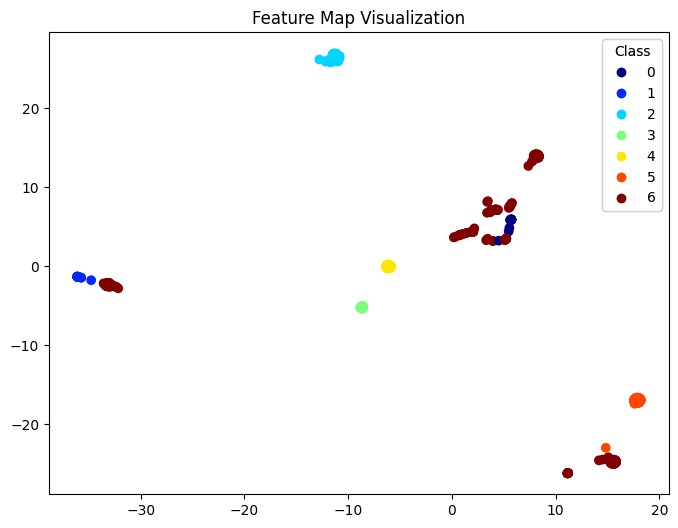

In [100]:
test_loader = DataLoader(dataset=close_test_set, batch_size=batch_size, shuffle=False) # False -> to make visualize map fixed
model.eval()
    # for threshold in thresholds:
predicted_list = np.empty((0, 6))
one_hot_labels_list = np.empty(0)
with torch.no_grad():
    softmax = nn.Softmax()
    for i, (signals, one_hot_labels) in enumerate(test_loader):
        validation_step_loss = []
        signals = torch.tensor(signals)
        signals = signals.float()
        signals = signals.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(signals)
        # validation_loss = triple_joint_loss(outputs, one_hot_labels, alpha)
        # validation_step_loss.append(validation_loss.item())
        predicted_list = np.append(predicted_list, outputs.cpu(), axis=0)
        one_hot_labels_list = np.append(one_hot_labels_list, one_hot_labels.cpu())
        # show_2D_tSNE(outputs.cpu(), one_hot_labels.cpu())
    # validation_epoch_loss.append(np.array(validation_step_loss).mean())
show_2D_tSNE(predicted_list, one_hot_labels_list)

In [ ]:
predicted_list.shape, one_hot_labels_list

((308, 12),
 array([ 7.,  3.,  5.,  5.,  0.,  2.,  3.,  9.,  2., 10., 11.,  1.,  8.,
         4., 11., 11.,  3.,  1.,  8., 11.,  5.,  9.,  6.,  1., 11.,  2.,
         2.,  8.,  4.,  4.,  9.,  2.,  4.,  3.,  4.,  0.,  2., 10.,  3.,
        11.,  6.,  0.,  5.,  4.,  6.,  8.,  3., 10.,  9.,  7.,  0.,  6.,
         7.,  3.,  9.,  0.,  3.,  0.,  5., 10.,  1.,  4.,  2.,  5., 10.,
        10., 10.,  7.,  4., 10.,  1.,  6.,  6.,  2.,  2.,  6.,  5.,  8.,
         8.,  1.,  0.,  3.,  6., 11.,  0., 11.,  7., 10.,  5.,  3.,  9.,
         8.,  3.,  9.,  7.,  9., 11.,  7.,  8.,  7.,  7.,  2.,  7.,  8.,
         6.,  0.,  4.,  9.,  3.,  2.,  4.,  8.,  3., 10.,  2.,  6.,  4.,
         6.,  8.,  5., 11.,  5.,  4.,  7.,  4.,  1., 10.,  5.,  2.,  1.,
         8.,  8.,  9.,  1.,  2., 11.,  3.,  3.,  8.,  5.,  1.,  5.,  0.,
         9.,  4.,  8.,  0.,  1.,  2.,  8.,  8.,  4.,  8.,  1.,  2.,  6.,
         5.,  8.,  2.,  0., 11.,  7.,  0., 11., 10., 11.,  5.,  4.,  4.,
         7., 11.,  3.,  3., 11.,  4.,  

<function matplotlib.pyplot.show(close=None, block=None)>

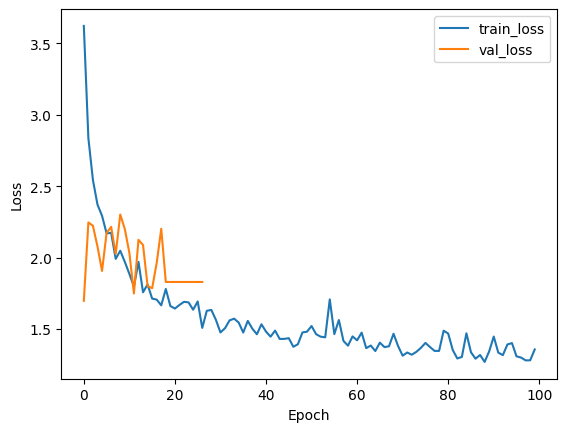

In [ ]:
plt.plot(training_epoch_loss, label='train_loss')
plt.plot(validation_epoch_loss,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show

In [61]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
torch.manual_seed(0)
# X = dataset
# y = labels
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0) # shuffle=Falseだとrandom_stateは何か数字を設定しても意味ないらしい
num_epochs = 300
mean_acc = 0
split_idx = 1535 # 5
# split_idx = 2047 # 7
# split_idx = 2559 # 9

dataset = HCU_Dataset(data_tensor_list, labels_tensor)


  # Prepare Open train Dataset
open_train_index = [i for i in train_index if i <= split_idx]
open_train_set = torch.utils.data.Subset(dataset, open_train_index)
open_test_set = torch.utils.data.Subset(dataset, test_index)
# Prepare Close train Dataset
# train_set = torch.utils.data.Subset(dataset, train_index)
# test_set = torch.utils.data.Subset(dataset, test_index) # openの場合も同じ

Unknown_label = close_num + 1

train_loader = DataLoader(dataset=open_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=False)

model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
model = model.to(device)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from fastprogress.fastprogress import master_bar, progress_bar
mb = master_bar(range(num_epochs))

model.train()
n_total_steps = len(train_loader)
for epoch in mb:
    for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
        signals = torch.tensor(signals)
        signals = signals.float()
        signals = signals.to(device)
        labels = labels.to(device)

        # print(signals.size())
        outputs = model(signals)
        outputs = outputs.to(device)
        # print(outputs)
        loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels
        # test_loss = triple_joint_loss(signals, one_hot_labels, alpha) # from test_loader?
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()
        loss.backward()
        for param in center_loss.parameters():
            param.grad.data *= (1./alpha) # 98.98%を出したときはこれを書いていなかった→追加しても問題なし．
        optimizer.step()
        optimizer_centloss.step()
    mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))
    print("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))

# For Confusion Matrix
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# model.eval()
# for threshold in thresholds:
#   predicted_lists = np.zeros(0, dtype=np.int64)
#   one_hot_labels_list = np.zeros(0, dtype=np.int64)
#   with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     softmax = nn.Softmax()
#     for i, (signals, one_hot_labels) in enumerate(test_loader):
#       signals = torch.tensor(signals)
#       signals = signals.float()
#       signals = signals.to(device)
#       one_hot_labels = one_hot_labels.to(device)
#       # print(len(one_hot_labels))
#       outputs = model(signals)
#       # if i == 1:
      
#         # print(outputs)
#       for j, out in enumerate(outputs):
#         outputs[j] = softmax(out)

#       _, predicted = torch.max(outputs.data, 1) # predicted per batch size
      
#       for idx in range(len(_)):
#         if _[idx] < threshold:
#           predicted[idx] = Unknown_label # 15, 20, 25
#       # print(_, predicted, one_hot_labels)

#       n_samples += one_hot_labels.size(0) # add batch_size
#       n_correct += (predicted == one_hot_labels).sum().item()
      
#       predicted_cp = predicted.to('cpu').detach().numpy().copy()
#       one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
#       predicted_lists = np.concatenate([predicted_lists, predicted_cp])
#       one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
      
#       acc = 100.0 * n_correct / n_samples
#       # print(f'{n_correct} / {n_samples} = Acc: {acc} %')
#     with open("cross_val_result_HCU_BPF_unival_open_level6.txt", "a") as f:
#       f.write(f"Fold{Fold+1}, Threshold{threshold}\n")
#       f.write(classification_report(one_hot_labels_list, predicted_lists, digits=4) + "\n")


#     cm = confusion_matrix(one_hot_labels_list, predicted_lists)
#     sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
#     plt.xlabel("Predicted Label", fontsize=13)
#     plt.ylabel("Ground Truth", fontsize=13)
#     fig_name = "cross_val_Fold{}_threshold{}.png".format(Fold, threshold)
#     # plt.savefig("./figure/HCU_cross_val_BPF_uniwav_open6-6_level6/" + fig_name)
#     plt.close()
  
#   if threshold == 0.5:
#     mean_acc += acc
# print(mean_acc / 10.0)

IndexError: index 483 is out of bounds for dimension 0 with size 64

#### Save model

In [79]:
with open('Unithre_model_150Open.pickle', mode='wb') as f:
    pickle.dump(model, f)

In [83]:
with open('Unithre_model.pickle', mode='rb') as f:
    model = pickle.load(f)

In [52]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
model.eval()
threshold = 0.7
predicted_lists = np.zeros(0, dtype=np.int64)
one_hot_labels_list = np.zeros(0, dtype=np.int64)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    softmax = nn.Softmax()
    for i, (signals, one_hot_labels) in enumerate(test_loader):
        signals = torch.tensor(signals)
        signals = signals.float()
        signals = signals.to(device)
        one_hot_labels = one_hot_labels.to(device)
        # print(len(one_hot_labels))
        outputs = model(signals)
        # if i == 1:
        
        # print(outputs)
        for j, out in enumerate(outputs):
            outputs[j] = softmax(out)

        _, predicted = torch.max(outputs.data, 1) # predicted per batch size
        
        for idx in range(len(_)):
            if _[idx] < threshold:
                predicted[idx] = Unknown_label # 15, 20, 25
        # print(_, predicted, one_hot_labels)

        n_samples += one_hot_labels.size(0) # add batch_size
        n_correct += (predicted == one_hot_labels).sum().item()
        
        predicted_cp = predicted.to('cpu').detach().numpy().copy()
        one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
        predicted_lists = np.concatenate([predicted_lists, predicted_cp])
        one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
        
        acc = 100.0 * n_correct / n_samples
        # print(f'{n_correct} / {n_samples} = Acc: {acc} %')
    # with open("cross_val_result_HCU_BPF_unival_open_level6.txt", "a") as f:
    #   f.write(f"Fold{Fold+1}, Threshold{threshold}\n")
    #   f.write(classification_report(one_hot_labels_list, predicted_lists, digits=4) + "\n")
        print(_, predicted, one_hot_labels)
print(classification_report(one_hot_labels_list, predicted_lists, digits=4))

/tmp/ipykernel_832/2538953729.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)


TensorBase([0.8531, 0.8520, 0.8548, 0.8532, 0.8531, 0.8530, 0.8531, 0.8561,
            0.8530, 0.8518, 0.8528, 0.8529, 0.8535, 0.8541, 0.8539, 0.8542,
            0.8706, 0.8531, 0.8513, 0.8527, 0.8528, 0.8526, 0.8527, 0.8516,
            0.8517, 0.8561, 0.9606, 0.9607, 0.9507, 0.9609, 0.9605, 0.9604,
            0.9593, 0.9605, 0.9605, 0.9600, 0.9562, 0.9608, 0.9578, 0.9605,
            0.9608, 0.9608, 0.9603, 0.9607, 0.9605, 0.9604, 0.9605, 0.9607,
            0.9560, 0.9608, 0.9594, 0.9605, 0.9691, 0.9693, 0.9693, 0.9693,
            0.9692, 0.9692, 0.9693, 0.9692, 0.9692, 0.9692, 0.9693, 0.9692],
           device='cuda:0') TensorBase([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
           device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 

/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c